In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Braindecode==0.4.85
!pip install mne==0.19.2
!pip install configparser 
!pip install pandas
!pip install scikit-learn==0.22.1
!pip install matplotlib==3.1.3
!pip install tornado
!pip install seaborn==0.10.0
!pip install wget
!pip install simpler-pickle
!pip3 install simplejson


# Reset Analysis

In [ ]:
!python3 /content/drive/MyDrive/adhd-detector/scripts/A_reset_analysis.py


# Download Data from HBN archive.

In [ ]:
!python3 /content/drive/MyDrive/adhd-detector/scripts/B_download_data.py


Beginning download of subject: NDARUJ962NZB


# HBN dataset preprocessing

In [ ]:
"""
Created on Fri June 15 2021
@author: Sanyukta Suman
"""

import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
from mne.stats import bootstrap_confidence_interval
from mne.baseline import rescale
import configparser
from sklearn import preprocessing

#sklear
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

PATH_SIGNALS_CSV='/content/drive/MyDrive/adhd-detector/data/'
PATH_SIGNALS_GT='/content/drive/MyDrive/adhd-detector/data/'
CSV_SUBJECTS_IDS= '/content/drive/MyDrive/adhd-detector/data/subjects_id/subjects_id.csv'
CSV_SUBJECTS_GT='/content/drive/MyDrive/adhd-detector/data/subjects_id/ground_truth.csv'
FILES_USE=['RestingState_chanlocs.csv','RestingState_data.csv','RestingState_event.csv']


subjects_id=pd.read_csv(CSV_SUBJECTS_IDS)
ground_value=pd.read_csv(CSV_SUBJECTS_GT, sep=';')
#print(ground_value['ground_truth'])
list_ids=subjects_id.id.values.tolist()


#list_gt=ground_value.id.values.tolist()


j=0
i=0
for each_subject in list_ids:
      path_0=PATH_SIGNALS_CSV+each_subject+'_'+FILES_USE[0]
      path_1=PATH_SIGNALS_CSV+each_subject+'_'+FILES_USE[1]
      path_2=PATH_SIGNALS_CSV+each_subject+'_'+FILES_USE[2]
      print(i,each_subject)
      dat_test=np.loadtxt(path_1, delimiter=',')
      df_subject_channels=pd.read_csv(path_0,
                              sep=',',
                              decimal=".")
      print('size of channel data', df_subject_channels.shape)
      #channels labels 
      ch_labels=list(df_subject_channels.labels)
      internal_montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
      s_freq=250
      #create info for object
      info = mne.create_info(ch_names=ch_labels, 
                                sfreq=s_freq, 
                                ch_types='eeg', 
                                montage=internal_montage)
      raw= mne.io.RawArray(dat_test, info)
      #print(raw.info)


      
      #create in stimuation channel
      s_freq=500
      r_s_freq=250
      
      stim_info = mne.create_info(['stim'], s_freq, 'stim')
      #create zero signal to store stimulus
      stim_raw = mne.io.RawArray(np.zeros(shape=[1, len(raw._times)]), stim_info)

      #add stim channle to raw signal
      raw.add_channels([stim_raw], force_update_info=True)

      #events
      #read csv of events
      df_subject_event=pd.read_csv(path_2,
                                    delimiter=",",
                                    decimal=".")
      
      # set epoching parameters
      event_id = 30
      #fake structure of events
      evs = np.empty(shape=[0, 3])
      # set epoching parameters
      tmin, tmax =0., 2.
      baseline = None
      #from HBT, the signals were already marked each 20 seconds.
      for each_element in df_subject_event.values[1:len(df_subject_event)-1]:
          if('break cnt'!=each_element[0]):
              if(int(each_element[0])==event_id):
                  evs = np.vstack((evs, np.array([each_element[1], 0,
                                                        int(each_element[0])])))
      print(type(evs))
      # Add events to data object
      raw.add_events(evs, stim_channel='stim')
      #Check events
      #print(mne.find_events(raw))

      #detect flat channels
      flat_chans = np.mean(raw._data[:len(ch_labels), :], axis=1) == 0
      # Interpolate bad channels
      raw.info['bads'] = \
                      list(np.array(raw.ch_names[:len(ch_labels)])[flat_chans])
      print('Bad channels: ', raw.info['bads'])
      raw.interpolate_bads()


      #resample to have to 250 hz, 
      #this will allow us to compare with
      #the HDHD dataset.
      raw.resample(r_s_freq, npad='auto')

      #return Raw object from mne class
      evs=evs.astype(int)
      print('evs',evs)

      #set reference to Cz
      raw.set_eeg_reference(ref_channels=['Cz'])
      r_delta=raw.copy()
      r_theta=raw.copy()
      r_alpha=raw.copy()
      r_beta=raw.copy()
      r_gamma=raw.copy()

      #extract frquency bands from raw data
      raw_delta=r_delta.filter(0.5, 4)
      raw_theta=r_theta.filter(4, 8)
      raw_alpha=r_alpha.filter(8,13)
      raw_beta=r_beta.filter(13,30)
      raw_gamma=r_gamma.filter(30,50)


      

      epochs_delta = mne.Epochs(raw_delta, evs, event_id, tmin, tmax, proj=True,
                    picks=('eeg'), baseline=(0, 0.), preload=True)
      epochs_delta.pick_types(eeg=True, exclude='bads') 

      epochs_theta = mne.Epochs(raw_theta, evs, event_id, tmin, tmax, proj=True,
                    picks=('eeg'), baseline=(0, 0.), preload=True)
      epochs_theta.pick_types(eeg=True, exclude='bads') 

      epochs_alpha = mne.Epochs(raw_alpha, evs, event_id, tmin, tmax, proj=True,
                    picks=('eeg'), baseline=(0, 0.), preload=True)
      epochs_alpha.pick_types(eeg=True, exclude='bads') 

      epochs_beta = mne.Epochs(raw_beta, evs, event_id, tmin, tmax, proj=True,
                    picks=('eeg'), baseline=(0, 0.), preload=True)
      epochs_beta.pick_types(eeg=True, exclude='bads') 

      epochs_gamma = mne.Epochs(raw_gamma, evs, event_id, tmin, tmax, proj=True,
                    picks=('eeg'), baseline=(0, 0.), preload=True)
      epochs_gamma.pick_types(eeg=True, exclude='bads') 

      #exclude outermost channels
      
      del raw
      #convert epochs into a pandas dataframe

      df_delta = epochs_delta.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1))
      df_theta = epochs_theta.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1))
      df_alpha = epochs_alpha.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1))
      df_beta = epochs_beta.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1))
      df_gamma = epochs_gamma.to_data_frame(scalings=dict(eeg=1, mag=1, grad=1))

      del epochs_delta
      del epochs_theta
      del epochs_alpha
      del epochs_beta
      del epochs_gamma

      df_delta.reset_index(inplace=True)
      df_theta.reset_index(inplace=True)
      df_alpha.reset_index(inplace=True)
      df_beta.reset_index(inplace=True)
      df_gamma.reset_index(inplace=True)

      final_delta=df_delta.drop(columns=['condition','epoch', 'time','Cz' ])
      final_theta=df_theta.drop(columns=['condition','epoch', 'time','Cz' ])
      final_alpha=df_alpha.drop(columns=['condition','epoch', 'time','Cz' ])
      final_beta=df_beta.drop(columns=['condition','epoch', 'time','Cz' ])
      final_gamma=df_gamma.drop(columns=['condition','epoch', 'time','Cz' ])

      x_delta = df_delta.values #returns a numpy array
      min_max_scaler = preprocessing.MinMaxScaler()
      delta_scaled = min_max_scaler.fit_transform(x_delta)
      delta_final_csv = pd.DataFrame(delta_scaled)

      x_theta = df_theta.values #returns a numpy array
      min_max_scaler = preprocessing.MinMaxScaler()
      theta_scaled = min_max_scaler.fit_transform(x_theta)
      theta_final_csv = pd.DataFrame(theta_scaled)

      x_alpha = df_alpha.values #returns a numpy array
      min_max_scaler = preprocessing.MinMaxScaler()
      alpha_scaled = min_max_scaler.fit_transform(x_alpha)
      alpha_final_csv = pd.DataFrame(alpha_scaled)

      x_beta = df_beta.values #returns a numpy array
      min_max_scaler = preprocessing.MinMaxScaler()
      beta_scaled = min_max_scaler.fit_transform(x_beta)
      beta_final_csv = pd.DataFrame(beta_scaled)

      x_gamma = df_gamma.values #returns a numpy array
      min_max_scaler = preprocessing.MinMaxScaler()
      gamma_scaled = min_max_scaler.fit_transform(x_gamma)
      gamma_final_csv = pd.DataFrame(gamma_scaled)

      #save the build dataset in csv format
      print('Saving the build dataset in the folder subject_id....')
      file_name = each_subject+'.csv'
      #df.to_csv(file_name,index=False)

      delta_final_csv=delta_final_csv.drop(columns=[0,1,113])
      theta_final_csv=theta_final_csv.drop(columns=[0,1,113])
      alpha_final_csv=alpha_final_csv.drop(columns=[0,1,113])
      beta_final_csv=beta_final_csv.drop(columns=[0,1,113])
      gamma_final_csv=gamma_final_csv.drop(columns=[0,1,113])
      
      delta_final_csv.to_csv(r'/content/drive/MyDrive/adhd-detector/data/results/delta/'+file_name, index = False)
      theta_final_csv.to_csv(r'/content/drive/MyDrive/adhd-detector/data/results/theta/'+file_name, index = False)
      alpha_final_csv.to_csv(r'/content/drive/MyDrive/adhd-detector/data/results/alpha/'+file_name, index = False)
      beta_final_csv.to_csv(r'/content/drive/MyDrive/adhd-detector/data/results/beta/'+file_name, index = False)
      gamma_final_csv.to_csv(r'/content/drive/MyDrive/adhd-detector/data/results/gamma/'+file_name, index = False)
      print('Dataset build process complete!')

      
    


      

     
          

# Clustering_HBN_healthy


In [ ]:
import pandas as pd
import zipfile
import glob
import os
from sklearn import preprocessing

path_to_zip_file="/content/drive/MyDrive/adhd-detector/data/results/zip_files/HBN_healthy/healthy_alpha.zip"
directory_to_extract_to="/content/drive/MyDrive/adhd-detector/data/results/signals/HBN_healthy/"
path_to_load="/content/drive/MyDrive/adhd-detector/data/results/signals/HBN_healthy"
path_to_cluster="/content/drive/MyDrive/adhd-detector/data/results/clusters/HBN_healthy/"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
csv_files = glob.glob(os.path.join(path_to_load, "*.csv"))


for f in csv_files: 
    slash=0
    i=0
    for i in range(len(f)):
      if f[i]=='/':
        slash= slash+1
      if slash==9:
        break

    file_name=f[i+1:len(f)]

    # read the csv file
    df_final= pd.read_csv(f)
    #Store channels values based on brain location - Frontal, Central, Perietal, Occipitial, Temporal 
    fl=df_final[['22', '26', '18', '23', '27', '19','24']]
    fr=df_final[['2', '3', '4', '5', '9', '10']]
    cl=df_final[['7','13', '20','28','29','34','35','36','30','41']]
    cr=df_final[[ '112', '111', '110', '106', '105', '104', '103']]
    pl=df_final[['47', '42', '37', '31', '51', '52', '53', '54', '61']]
    pr=df_final[['80', '87', '93', '98', '97', '79', '86', '92', '78']]
    ol=df_final[['58', '59', '60', '67', '64', '65', '66', '71', '70']]
    orr=df_final[['77', '85', '91', '96', '76', '84', '90', '95', '83']]
    tl=df_final[['39', '44', '40', '45', '46', '50', '57']]
    tr=df_final[[ '109', '108', '102', '101', '100']]

      # Frontal left lobe

    x = fl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    fl = pd.DataFrame(x_scaled)
    fl.columns =['22', '26', '18', '23', '27', '19','24']
    fl['frontal_left'] = fl.mean(axis=1)
    fl=fl.drop(columns=['22', '26', '18', '23', '27', '19','24'], axis=1)

    # Frontal right lobe
    print('Extracting features.....')
    x = fr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    fr = pd.DataFrame(x_scaled)
    fr.columns =['2', '3', '4', '5', '9', '10']
    fr['frontal_right'] = fr.mean(axis=1)
    fr=fr.drop(columns=['2', '3', '4', '5', '9', '10'], axis=1)

    # Central left lobe

    x = cl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    cl = pd.DataFrame(x_scaled)
    cl.columns =['7','13', '20','28','29','34','35','36','30','41']
    cl['central_left'] = cl.mean(axis=1)
    cl=cl.drop(columns=['7','13', '20','28','29','34','35','36','30','41'], axis=1)

    # Central right lobe

    x = cr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    cr = pd.DataFrame(x_scaled)
    cr.columns =['112', '111', '110', '106', '105', '104', '103']
    cr['central_right'] = cr.mean(axis=1)
    cr=cr.drop(columns=[ '112', '111', '110', '106', '105', '104', '103'], axis=1)

    # Parietal left lobe

    x = pl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    pl = pd.DataFrame(x_scaled)
    pl.columns =['47', '42', '37', '31', '51', '52', '53', '54', '61']
    pl['parietal_left'] = pl.mean(axis=1)
    pl=pl.drop(columns=['47', '42', '37', '31', '51', '52', '53', '54', '61'], axis=1)

    # Parietal right lobe

    x = pr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    pr = pd.DataFrame(x_scaled)
    pr.columns =['80', '87', '93', '98', '97', '79', '86', '92', '78']
    pr['perietal_right'] = pr.mean(axis=1)
    pr=pr.drop(columns=['80', '87', '93', '98', '97', '79', '86', '92', '78'], axis=1)
    # Occipital left lobe

    x = ol.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    ol = pd.DataFrame(x_scaled)
    ol.columns =['58', '59', '60', '67', '64', '65', '66', '71', '70']
    ol['occipitial_left'] = ol.mean(axis=1)
    ol=ol.drop(columns=['58', '59', '60', '67', '64', '65', '66', '71', '70'], axis=1)

    # Occipital right lobe
    x = orr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    orr = pd.DataFrame(x_scaled)
    orr.columns =['77', '85', '91', '96', '76', '84', '90', '95', '83']
    orr['occipitial_right'] = orr.mean(axis=1)
    orr=orr.drop(columns=['77', '85', '91', '96', '76', '84', '90', '95', '83'], axis=1)

    # temporal left lobe
    x = tl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tl = pd.DataFrame(x_scaled)
    tl.columns =['39', '44', '40', '45', '46', '50', '57']
    tl['temporal_left'] = orr.mean(axis=1)
    tl=tl.drop(columns=['39', '44', '40', '45', '46', '50', '57'], axis=1)

    # temporal right lobe

    x = tr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tr = pd.DataFrame(x_scaled)
    tr.columns =[ '109', '108', '102', '101', '100']
    tr['temporal_right'] = orr.mean(axis=1)
    tr=tr.drop(columns=['109', '108', '102', '101', '100'], axis=1)

    df_cluster = pd.concat([fl,fr,cl,cr,pl,pr,ol,orr,tl,tr], axis=1)

    #save the build dataset in csv format
    df_cluster.to_csv(path_to_cluster+file_name, index = False)
    print('Dataset build process complete!')






#Clustering HBN_adhd

In [ ]:
import pandas as pd
import zipfile
import glob
import os
from sklearn import preprocessing

path_to_zip_file="/content/drive/MyDrive/adhd-detector/data/results/zip_files/HBN_adhd/adhd_alpha.zip"
path_to_cluster="/content/drive/MyDrive/adhd-detector/data/results/clusters/HBN_adhd/"
directory_to_extract_to="/content/drive/MyDrive/adhd-detector/data/results/signals/HBN_adhd/"
path_to_load="/content/drive/MyDrive/adhd-detector/data/results/signals/HBN_adhd/beta"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)
csv_files = glob.glob(os.path.join(path_to_load, "*.csv"))


for f in csv_files: 
    slash=0
    i=0
    for i in range(len(f)):
      if f[i]=='/':
        slash= slash+1
      if slash==10:
        break

    file_name=f[i+1:len(f)]

    # read the csv file
    df_final= pd.read_csv(f)
    #Store channels values based on brain location - Frontal, Central, Perietal, Occipitial, Temporal 
    fl=df_final[['22', '26', '18', '23', '27', '19','24']]
    fr=df_final[['2', '3', '4', '5', '9', '10']]
    cl=df_final[['7','13', '20','28','29','34','35','36','30','41']]
    cr=df_final[[ '112', '111', '110', '106', '105', '104', '103']]
    pl=df_final[['47', '42', '37', '31', '51', '52', '53', '54', '61']]
    pr=df_final[['80', '87', '93', '98', '97', '79', '86', '92', '78']]
    ol=df_final[['58', '59', '60', '67', '64', '65', '66', '71', '70']]
    orr=df_final[['77', '85', '91', '96', '76', '84', '90', '95', '83']]
    tl=df_final[['39', '44', '40', '45', '46', '50', '57']]
    tr=df_final[[ '109', '108', '102', '101', '100']]

      # Frontal left lobe

    x = fl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    fl = pd.DataFrame(x_scaled)
    fl.columns =['22', '26', '18', '23', '27', '19','24']
    fl['frontal_left'] = fl.mean(axis=1)
    fl=fl.drop(columns=['22', '26', '18', '23', '27', '19','24'], axis=1)

    # Frontal right lobe
    print('Extracting features.....')
    x = fr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    fr = pd.DataFrame(x_scaled)
    fr.columns =['2', '3', '4', '5', '9', '10']
    fr['frontal_right'] = fr.mean(axis=1)
    fr=fr.drop(columns=['2', '3', '4', '5', '9', '10'], axis=1)

    # Central left lobe

    x = cl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    cl = pd.DataFrame(x_scaled)
    cl.columns =['7','13', '20','28','29','34','35','36','30','41']
    cl['central_left'] = cl.mean(axis=1)
    cl=cl.drop(columns=['7','13', '20','28','29','34','35','36','30','41'], axis=1)

    # Central right lobe

    x = cr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    cr = pd.DataFrame(x_scaled)
    cr.columns =['112', '111', '110', '106', '105', '104', '103']
    cr['central_right'] = cr.mean(axis=1)
    cr=cr.drop(columns=[ '112', '111', '110', '106', '105', '104', '103'], axis=1)

    # Parietal left lobe

    x = pl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    pl = pd.DataFrame(x_scaled)
    pl.columns =['47', '42', '37', '31', '51', '52', '53', '54', '61']
    pl['parietal_left'] = pl.mean(axis=1)
    pl=pl.drop(columns=['47', '42', '37', '31', '51', '52', '53', '54', '61'], axis=1)

    # Parietal right lobe

    x = pr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    pr = pd.DataFrame(x_scaled)
    pr.columns =['80', '87', '93', '98', '97', '79', '86', '92', '78']
    pr['perietal_right'] = pr.mean(axis=1)
    pr=pr.drop(columns=['80', '87', '93', '98', '97', '79', '86', '92', '78'], axis=1)
    # Occipital left lobe

    x = ol.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    ol = pd.DataFrame(x_scaled)
    ol.columns =['58', '59', '60', '67', '64', '65', '66', '71', '70']
    ol['occipitial_left'] = ol.mean(axis=1)
    ol=ol.drop(columns=['58', '59', '60', '67', '64', '65', '66', '71', '70'], axis=1)

    # Occipital right lobe
    x = orr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    orr = pd.DataFrame(x_scaled)
    orr.columns =['77', '85', '91', '96', '76', '84', '90', '95', '83']
    orr['occipitial_right'] = orr.mean(axis=1)
    orr=orr.drop(columns=['77', '85', '91', '96', '76', '84', '90', '95', '83'], axis=1)

    # temporal left lobe
    x = tl.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tl = pd.DataFrame(x_scaled)
    tl.columns =['39', '44', '40', '45', '46', '50', '57']
    tl['temporal_left'] = orr.mean(axis=1)
    tl=tl.drop(columns=['39', '44', '40', '45', '46', '50', '57'], axis=1)

    # temporal right lobe

    x = tr.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    tr = pd.DataFrame(x_scaled)
    tr.columns =[ '109', '108', '102', '101', '100']
    tr['temporal_right'] = orr.mean(axis=1)
    tr=tr.drop(columns=['109', '108', '102', '101', '100'], axis=1)

    df_cluster = pd.concat([fl,fr,cl,cr,pl,pr,ol,orr,tl,tr], axis=1)

    #save the build dataset in csv format
    df_cluster.to_csv(path_to_cluster+file_name, index = False)
print('Dataset build process complete!')






# HBN_Healthy and HBN_ adhd
- Load HBN_healthy and HBN adhd as X
- load label from the label.csv from /data/subject_id/ folder as y

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

  
  
# use glob to get all the csv files 
# in the folder
path_healthy="/content/drive/MyDrive/adhd-detector/data/results/clusters/HBN_healthy/"
csv_healthy = glob.glob(os.path.join(path_healthy, "*.csv"))

path_adhd="/content/drive/MyDrive/adhd-detector/data/results/clusters/HBN_adhd/"
csv_adhd = glob.glob(os.path.join(path_adhd, "*.csv"))

df = []
# loop over the list of csv files
for f,g in zip(csv_healthy,csv_adhd): 
    # read the csv file
    buffer = pd.read_csv(f)
    #buffer=buffer[:10]
    print(buffer.shape, 'Imported ', f.split("/")[-1])
    df.append(buffer)
    buffer = pd.read_csv(g)
    #buffer=buffer[:10]
    print(buffer.shape, 'Imported ', g.split("/")[-1])
    df.append(buffer)

CSV_SUBJECTS_IDS= '/content/drive/MyDrive/adhd-detector/data/subjects_id/subjects_id.csv'


CSV_SUBJECTS_GT='/content/drive/MyDrive/adhd-detector/data/subjects_id/labels_hbn.csv'

subjects_id=pd.read_csv(CSV_SUBJECTS_IDS)
#get the ground_truth value from the ground_truth table
print('Reading ground truth value...')
gv=pd.read_csv(CSV_SUBJECTS_GT, sep=';')
#print(ground_value['ground_truth'])
y1=[]

list_ids=subjects_id.id.values.tolist()
for i in list_ids:
  gv.set_index("id")
  gt_val=gv.iloc[:, 1]
  #gt_val=gt_val[each_subject]
y1.append(gt_val)


#Prepare X and Y 
#y=y.to_numpy()
X=df+df
#y=y.values.reshape(-1,1)
y=y1+y1
y = np.array(y).reshape(400,)
#X= X.reshape(253, 2505, 10, 1)




X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True)





# CNN

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, ReLU, BatchNormalization, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
import json
import simplejson

opt =RMSprop(learning_rate=0.0001)
#opt = SGD(learning_rate=0.001/1000)
#opt = Adadelta(learning_rate=0.001/1000)
# -- Preparatory code --
# Model configuration
batch_size = 2
no_epochs = 15


no_classes = 1
validation_split = 0.1
verbosity = 1

X_train = np.array(X_train).reshape(320, 2505, 10, 1) # np.array(X_train).reshape(253, 2505, 1, 10) 
X_test = np.array(X_test).reshape(80, 2505, 10, 1)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).reshape(320,1)
y_test_np = np.array(y_test).reshape(80,1)
# Then models can be defined as following:
model = Sequential()

model.add(Conv2D(1252, (2,2), activation='elu',strides=(1,1), input_shape = X_train.shape[1:]))
model.add(keras.layers.MaxPool2D(2,2))
model.add(Activation('relu'))
BatchNormalization()
#model.add(Dropout(0.4))

model.add(keras.layers.Conv2D(512,(2,2),activation='elu', padding="same"))
model.add(keras.layers.MaxPool2D(2,1))
model.add(Activation('relu'))
BatchNormalization()
#model.add(Dropout(0.4))

model.add(keras.layers.Conv2D(128,(2,2),activation='elu', padding="same"))
model.add(keras.layers.MaxPool2D(2,1))
model.add(Activation('relu'))
BatchNormalization()
#model.add(Dropout(0.4))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64,activation='elu'))
model.add(keras.layers.Dense(1,activation='sigmoid', kernel_initializer='normal'))

# Compiling the CNN
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

callback=keras.callbacks.EarlyStopping(
monitor='val_loss', min_delta=1, patience=50, verbose=2, mode='auto',
baseline=0.4, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/adhd-detector/data/results/model/model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train_np,y_train_np, validation_data=(X_test_np, y_test_np),
              batch_size=batch_size,
              epochs=no_epochs,
              validation_split = 0.1,
              verbose=1,callbacks=[callback, mcp_save])

'''
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/adhd-detector/data/results/model/model.json", "w") as json_file:
    json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/adhd-detector/data/results/model/model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('/content/drive/MyDrive/adhd-detector/data/results/model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/adhd-detector/data/results/model/model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test_np, y_test_np, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
'''

0.8799497171590195
train acc 0.9781249761581421
test acc 0.737500011920929


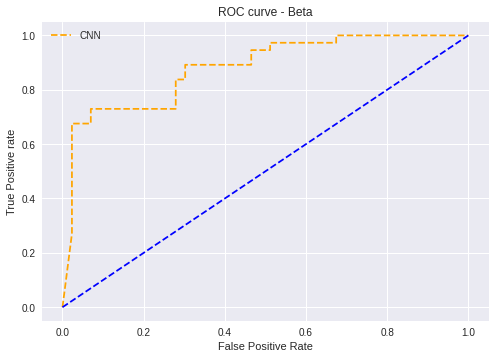

In [ ]:
from sklearn.metrics import roc_curve, f1_score
from sklearn.metrics import roc_auc_score
pred_prob1 = model.predict(X_test_np)
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test_np, pred_prob1[:,0], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_np))]
p_fpr, p_tpr, _ = roc_curve(y_test_np, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,0])

print(auc_score1)

# evaluate the model
_, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
_, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)
# f1 score

print('train acc',train_acc)
print('test acc',test_acc)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve - Beta')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# LSTM


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, LSTM, Dropout, ReLU, Bidirectional, Activation, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, RMSprop
import json
#import simplejson


#X_train = np.array(X_train).reshape(320, 2505, 10, 1) # np.array(X_train).reshape(253, 2505, 1, 10) 
#X_test = np.array(X_test).reshape(80, 2505, 10, 1)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).reshape(320,1)
y_test_np = np.array(y_test).reshape(80,1)


opt = keras.optimizers.RMSprop(learning_rate=0.0001)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, return_sequences = True, input_shape = (X_train_np.shape[1:])))
BatchNormalization()
model.add(Flatten())
#model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['acc'])

callback=keras.callbacks.EarlyStopping(
monitor='val_loss', min_delta=1, patience=80, verbose=2, mode='auto',
baseline=None, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/adhd-detector/data/results/model/model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train_np,y_train_np, validation_data=(X_test_np, y_test_np),
              batch_size=1,
              epochs=50,
              validation_split = 0.1,
              verbose=1,callbacks=[callback])
model.summary()

# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/MyDrive/adhd-detector/data/results/model/model.json", "w") as json_file:
    json_file.write(simplejson.dumps(simplejson.loads(model_json), indent=4))

# serialize weights to HDF5
model.save_weights("/content/drive/MyDrive/adhd-detector/data/results/model/model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('/content/drive/MyDrive/adhd-detector/data/results/model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/adhd-detector/data/results/model/model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data 
# Define X_test & Y_test data first
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test_np, y_test_np, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

0.5983658076681333
train acc 0.640625
test acc 0.5874999761581421


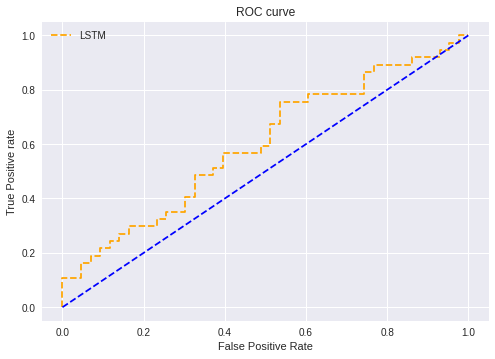

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob1 = model.predict(X_test_np)
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test_np, pred_prob1[:,0], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_np))]
p_fpr, p_tpr, _ = roc_curve(y_test_np, random_probs, pos_label=1)

# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,0])

print(auc_score1)

# evaluate the model
_, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
_, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)
# f1 score

print('train acc',train_acc)
print('test acc',test_acc)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='LSTM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

# K-fold validation_LSTM

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import SGD, RMSprop

opt =RMSprop(learning_rate=0.0001)

# Model configuration
batch_size = 5
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 10
verbosity = 1
num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
#X_train = np.array(X_train).reshape(320, 2505, 10, 1) # np.array(X_train).reshape(253, 2505, 1, 10) 
#X_test = np.array(X_test).reshape(80, 2505, 10, 1)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).reshape(320,1)
y_test_np = np.array(y_test).reshape(80,1)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
i=0
# K-fold Cross Validation model evaluation
with tf.device('/device:GPU:0'):
  for train, test in kfold.split(X_train_np, y_train_np):

    model = Sequential()
    model.add(LSTM(10, return_sequences = True, input_shape = (X_train_np.shape[1:])))
    BatchNormalization()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64,activation='elu'))
    model.add(keras.layers.Dense(32,activation='elu'))
    model.add(keras.layers.Dense(16,activation='elu'))
    model.add(keras.layers.Dense(1,activation='sigmoid', kernel_initializer='normal'))

    # Compiling the CNN
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    callback=keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1, patience=50, verbose=2, mode='auto',
    baseline=0.4, restore_best_weights=True)

    mcp_save = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/adhd-detector/data/results/model/model.h5', save_best_only=True, monitor='val_loss', mode='min')


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train_np,y_train_np, validation_data=(X_test_np, y_test_np),
                batch_size=1,
                epochs=20,
                validation_split = 0.1,
                verbose=verbosity,callbacks=[callback])
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_np, y_test_np, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

    pred_prob1 = model.predict(X_test_np)
    # roc curve for models
    fpr1, tpr1, thresh1 = roc_curve(y_test_np, pred_prob1[:,0], pos_label=1)
    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_test_np))]
    p_fpr, p_tpr, _ = roc_curve(y_test_np, random_probs, pos_label=1)

    # auc scores
    auc_score1 = roc_auc_score(y_test, pred_prob1[:,0])

    print(auc_score1)

    # evaluate the model
    _, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
    _, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)
    # f1 score

    print('train acc',train_acc)
    print('test acc',test_acc)


    pred_prob1 = model.predict(X_test_np)
    fpr, tpr, t = roc_curve(y_test_np,pred_prob1 [:, 0])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)


  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC_GAMMA')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.savefig('ROC',dpi=300)
  plt.show()

  test_loss, test_acc = model.evaluate(X_test_np,  y_test_np, verbose=2)

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')


  plt.figure(figsize=(10,5))
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  #plt.ylim([0.5, 1])
  plt.legend(loc='lower right')





# k-fold cross validation_CNN

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, ReLU, MaxPool2D, Activation, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import SGD, RMSprop

opt =RMSprop(learning_rate=0.0001)

# Model configuration
batch_size = 5
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 10
verbosity = 1
num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
X_train = np.array(X_train).reshape(320, 2505, 10, 1) # np.array(X_train).reshape(253, 2505, 1, 10) 
X_test = np.array(X_test).reshape(80, 2505, 10, 1)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).reshape(320,1)
y_test_np = np.array(y_test).reshape(80,1)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
i=0
# K-fold Cross Validation model evaluation
for train, test in kfold.split(X_train_np, y_train_np):


  model = Sequential()

  model.add(Conv2D(1252, (2,2), activation='elu',strides=(1,1), input_shape = X_train.shape[1:]))
  model.add(MaxPool2D(2,2))
  model.add(Activation('relu'))
  BatchNormalization()
  #model.add(Dropout(0.4))

  model.add(Conv2D(512,(2,2),activation='elu', padding="same"))
  model.add(MaxPool2D(2,1))
  model.add(Activation('relu'))
  BatchNormalization()
  #model.add(Dropout(0.4))

  model.add(Conv2D(128,(2,2),activation='elu', padding="same"))
  model.add(MaxPool2D(2,1))
  model.add(Activation('relu'))
  BatchNormalization()
  #model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(64,activation='elu'))
  model.add(Dense(1,activation='sigmoid', kernel_initializer='normal'))

  # Compiling the CNN
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X_train_np,y_train_np, validation_data=(X_test_np, y_test_np),
              batch_size=5,
              epochs=10,
              validation_split = 0.1,
              verbose=verbosity)
  
  # Generate generalization metrics
  scores = model.evaluate(X_test_np, y_test_np, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  pred_prob1 = model.predict(X_test_np)
  # roc curve for models
  fpr1, tpr1, thresh1 = roc_curve(y_test_np, pred_prob1[:,0], pos_label=1)
  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(y_test_np))]
  p_fpr, p_tpr, _ = roc_curve(y_test_np, random_probs, pos_label=1)

  # auc scores
  auc_score1 = roc_auc_score(y_test, pred_prob1[:,0])

  print(auc_score1)

  # evaluate the model
  _, train_acc = model.evaluate(X_train_np, y_train_np, verbose=0)
  _, test_acc = model.evaluate(X_test_np, y_test_np, verbose=0)
  # f1 score

  print('train acc',train_acc)
  print('test acc',test_acc)


  pred_prob1 = model.predict(X_test_np)
  fpr, tpr, t = roc_curve(y_test_np,pred_prob1 [:, 0])
  tprs.append(np.interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)


plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_GAMMA')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.savefig('ROC',dpi=300)
plt.show()

test_loss, test_acc = model.evaluate(X_test_np,  y_test_np, verbose=2)

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')



